<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Fractional Differentiation
    </h1>
  </div>  
</div>

This notebook explores fractional differentiation for financial time series using the `RiskLabAI` library.

In this tutorial, we will:
1.  Load and prepare a long-term S&P 500 price series from FRED.
2.  Visualize the memory-decay properties by plotting fractional differentiation weights.
3.  Apply both the standard (expanding window) and Fixed-Width Window (FFD) differentiation methods.
4.  Use an ADF test to find the minimum `d` that makes the series stationary.
5.  Demonstrate the `fractionally_differentiated_log_price` helper function to automate this process.

## 0. Setup and Imports

First, we import our libraries and the necessary modules from `RiskLabAI`, including our plotting utility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from fredapi import Fred
from dotenv import load_dotenv

# Import from our RiskLabAI package
import RiskLabAI.data.differentiation.differentiation as diff
import RiskLabAI.utils.publication_plots as pub_plots

# Set plotting backend for pandas
pd.options.plotting.backend = "matplotlib"

# Global Plotting Settings
SAVE_PLOTS = False
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300
SAVE_DIR = 'figs'

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Load and Prepare Data

We load daily S&P 500 price data from the Federal Reserve (FRED) database. This series is non-stationary and ideal for fractional differentiation.

In [2]:
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()

# To run the code on your computer, register for a free FRED API key 
# and place it in a .env file as FRED_API_KEY='YOUR_KEY'
FRED_API_KEY = os.environ.get('FRED_API_KEY')

if not FRED_API_KEY:
    print("Warning: FRED_API_KEY not found. Please set it in a .env file.")
    # Set a dummy key to allow the notebook to run, though it will fail to fetch data
    FRED_API_KEY = 'YOUR_FRED_API_KEY_HERE'
else:
    print("FRED API Key loaded.")

fred = Fred(api_key=FRED_API_KEY)

# Load S&P 500 data (daily, already OHLC-like)
series = fred.get_series('SP500', start_date="1990-01-01").dropna()

# Convert to DataFrame and log-transform
# Most diff functions expect a 'close' column
series_df = series.to_frame(name='close') 
close_log = np.log(series_df)

print("S&P 500 Daily Price Data:")
print(series_df.head())

FRED API Key loaded.
S&P 500 Daily Price Data:
              close
2015-11-16  2053.19
2015-11-17  2050.44
2015-11-18  2083.58
2015-11-19  2081.24
2015-11-20  2089.17


## 2. Snippet 5.1: Plotting Fractional Weights

Before differentiating, let's visualize the weights. Fractional differentiation controls the "memory" of a time series:
* **d = 0:** Full memory (original series).
* **d = 1:** No memory (standard returns).
* **0 < d < 1:** Decaying memory.

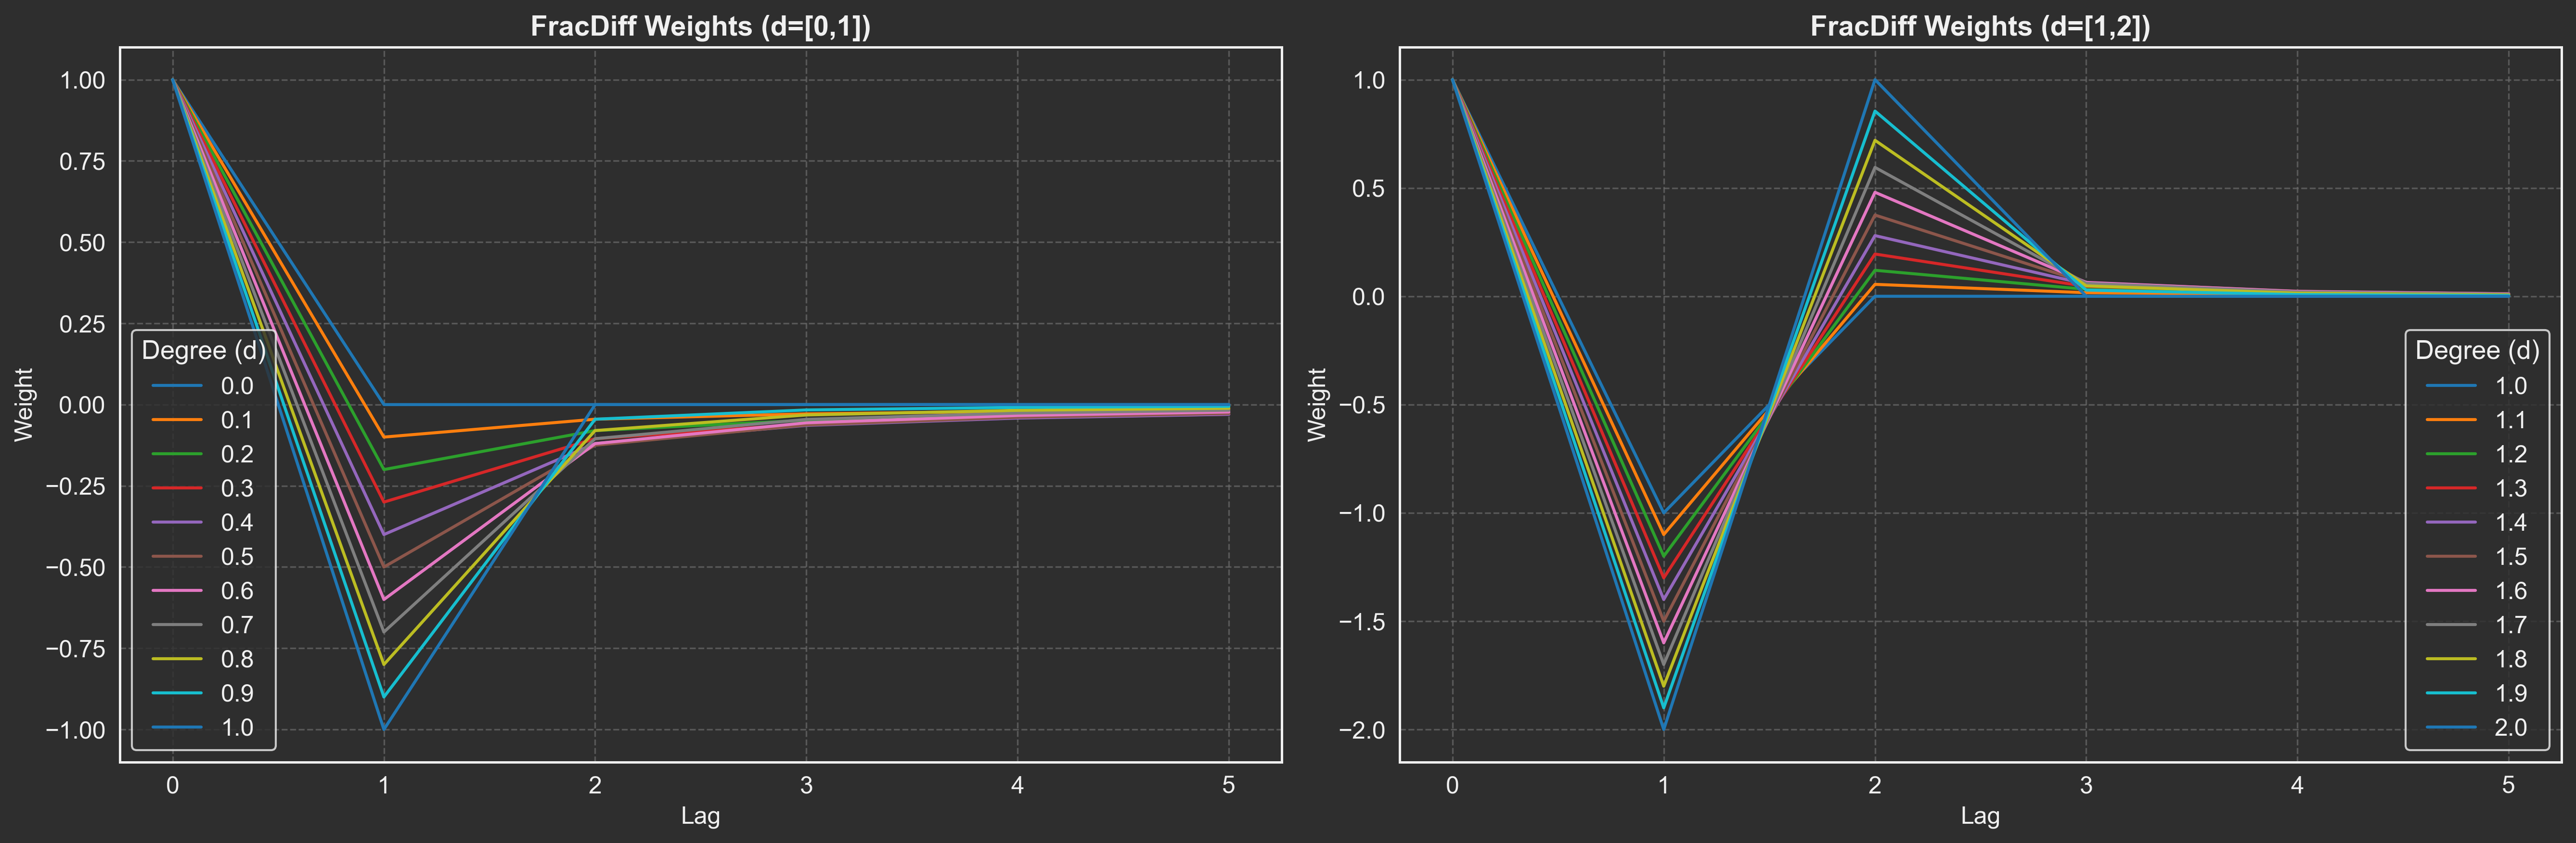

In [3]:
# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot weights for d in [0, 1]
diff.plot_weights((0.0, 1.0), 11, 6, ax=ax1)
pub_plots.apply_plot_style(
    ax1, 
    'FracDiff Weights (d=[0,1])', 
    'Lag', 
    'Weight', 
    legend_title='Degree (d)'
)

# Plot weights for d in [1, 2]
diff.plot_weights((1, 2), 11, 6, ax=ax2)
pub_plots.apply_plot_style(
    ax2, 
    'FracDiff Weights (d=[1,2])', 
    'Lag', 
    'Weight', 
    legend_title='Degree (d)'
)

plt.tight_layout()
pub_plots.finalize_plot(fig, "fracdiff_weights.png")

## 3. Standard (Expanding Window) FracDiff

This method calculates the differentiated series using an expanding window. We'll use a twin-Y-axis plot to show the original log-price and the differentiated series on different scales.

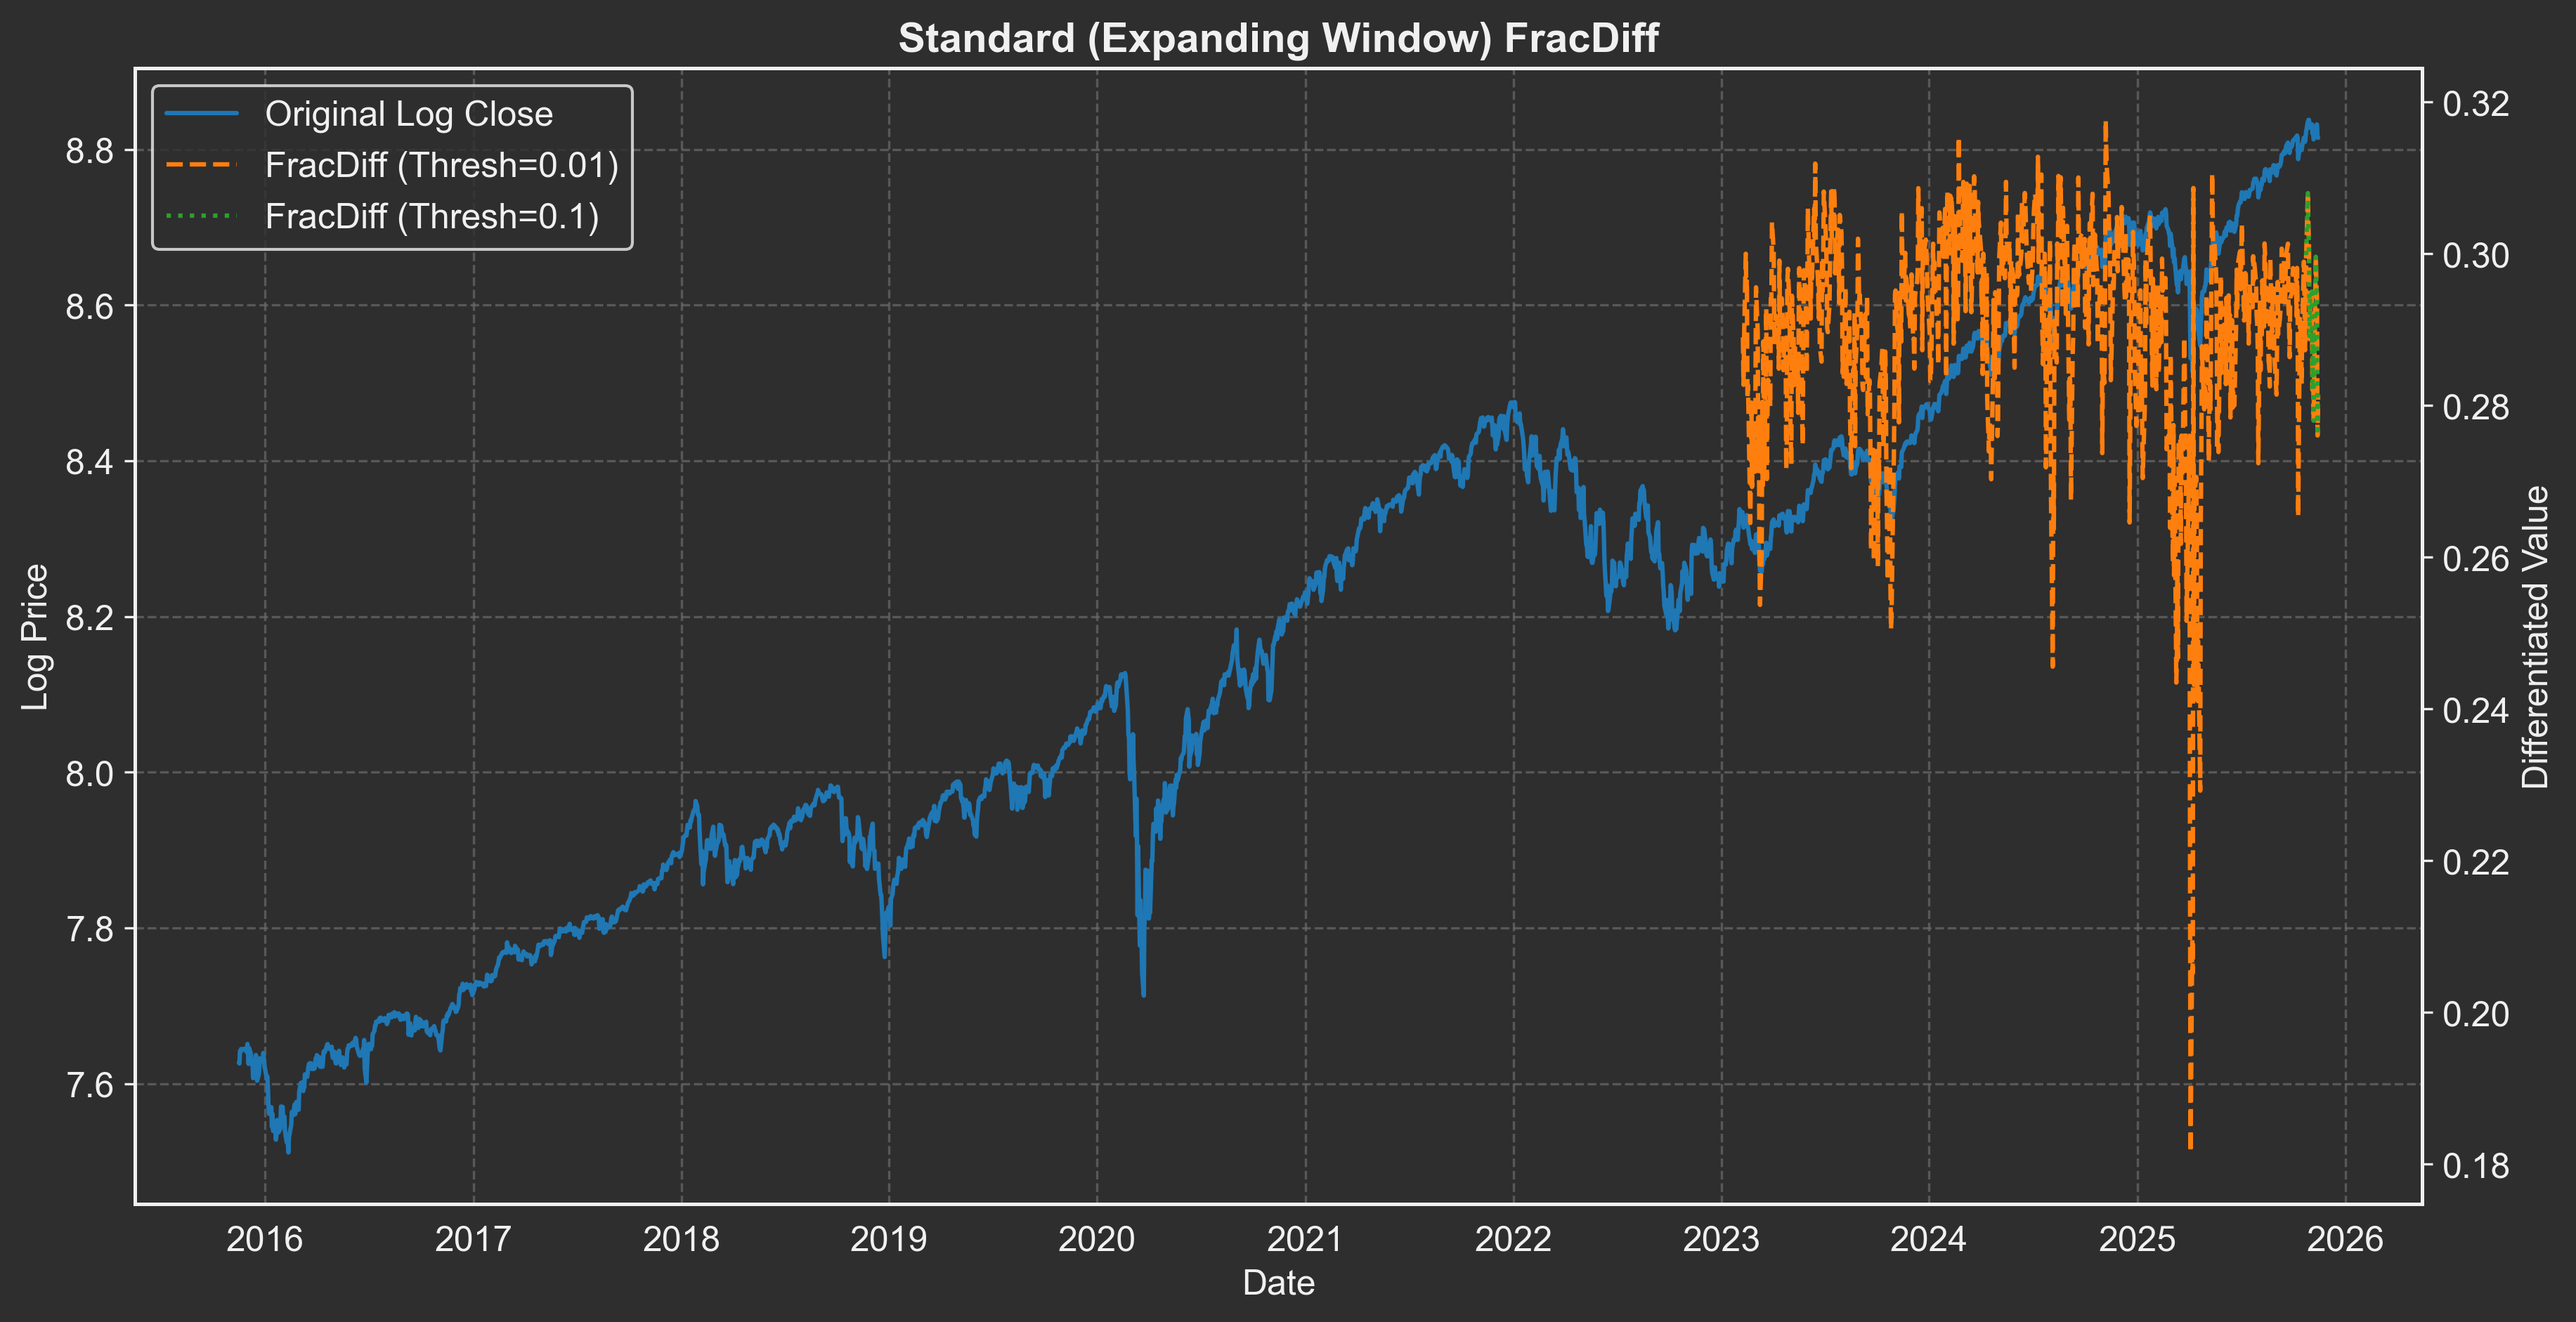

In [4]:
# Calculate standard fractional differentiation on log-price
close_fd_std_short = diff.fractional_difference_std(
    close_log, 
    degree=0.4, 
    threshold=0.01
).iloc[:, 0]

close_fd_std_long = diff.fractional_difference_std(
    close_log, 
    degree=0.4, 
    threshold=0.1
).iloc[:, 0]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(close_log.index, close_log['close'], label='Original Log Close', color='C0')

# Create secondary Y-axis
ax2 = ax.twinx()
ax2.plot(close_fd_std_short.index, close_fd_std_short, label='FracDiff (Thresh=0.01)', color='C1', linestyle='--')
ax2.plot(close_fd_std_long.index, close_fd_std_long, label='FracDiff (Thresh=0.1)', color='C2', linestyle=':')

# Apply styling
pub_plots.apply_plot_style(
    ax, 
    'Standard (Expanding Window) FracDiff', 
    'Date', 
    'Log Price'
)
ax2.set_ylabel('Differentiated Value')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')
ax2.grid(False)

pub_plots.finalize_plot(fig, "standard_fracdiff_plot.png")

## 4. Fixed-Width Window (FFD) FracDiff

The Fixed-Width Window (FFD) method is more efficient. It uses a fixed-size window determined by the weight `threshold`. This is the most practical and recommended method, and our library implements it efficiently using `np.convolve`.

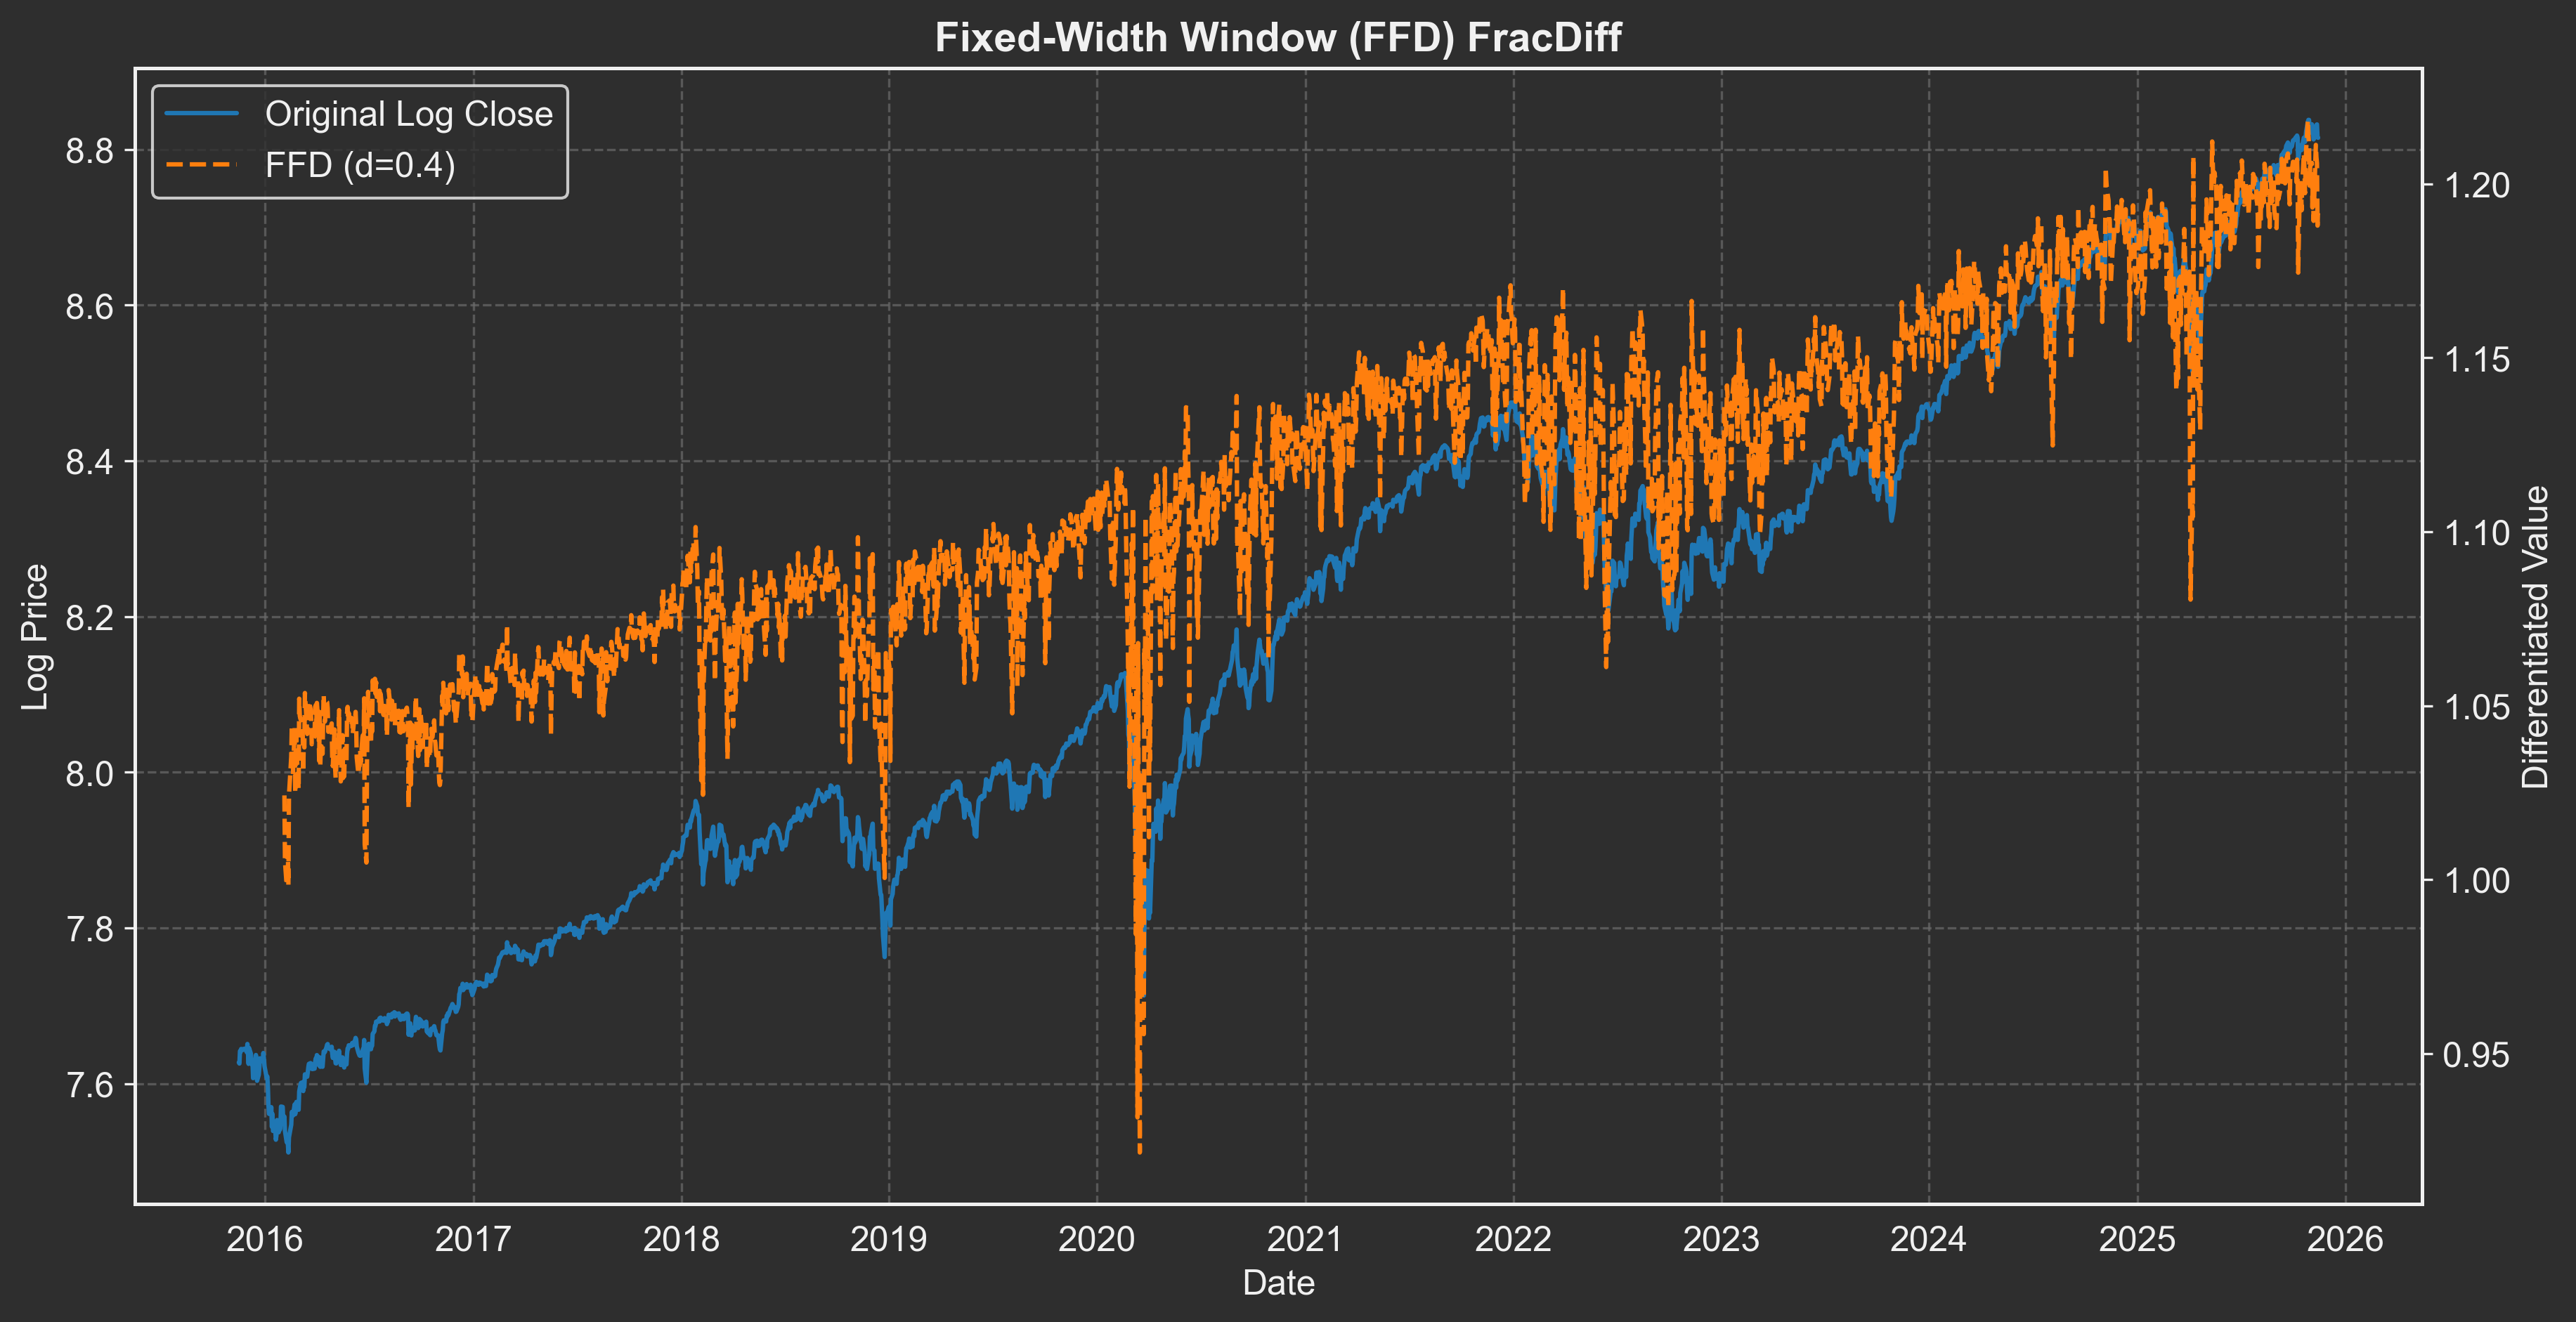

In [5]:
# Calculate FFD on log-price
close_ffd = diff.fractional_difference_fixed(
    close_log, 
    degree=0.4, 
    threshold=1e-3
).iloc[:, 0]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(close_log.index, close_log['close'], label='Original Log Close', color='C0')

ax2 = ax.twinx()
ax2.plot(close_ffd.index, close_ffd, label='FFD (d=0.4)', color='C1', linestyle='--')

pub_plots.apply_plot_style(
    ax, 
    'Fixed-Width Window (FFD) FracDiff', 
    'Date', 
    'Log Price'
)
ax2.set_ylabel('Differentiated Value')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')
ax2.grid(False)

pub_plots.finalize_plot(fig, "ffd_fracdiff_plot.png")

## 5. Finding the Optimal 'd'

The main goal is to make a time series **stationary** while preserving as much memory as possible. We iterate through `d` values to find the *minimum `d`* that passes the Augmented Dickey-Fuller (ADF) test for stationarity.

This function expects the raw price `DataFrame` as it applies the log-transform internally.

In [6]:
# Find the optimal 'd' by testing for stationarity
# We pass the raw price DataFrame (series_df) here
out = diff.find_optimal_ffd_simple(series_df, p_value_threshold=0.05)

print("ADF Test Results per 'd':")
print(out)

ADF Test Results per 'd':
       adfStat          pVal  lags  nObs  95% conf  corr
d                                                       
0.0  -0.357958  9.168852e-01     1  3650 -2.862332   NaN
0.1  -0.557481  8.803031e-01     1  3643 -2.862334   NaN
0.2  -0.990885  7.565744e-01     1  3640 -2.862334   NaN
0.3  -1.574204  4.965376e-01     1  3639 -2.862335   NaN
0.4  -2.289742  1.752976e-01     1  3640 -2.862334   NaN
0.5  -3.313684  1.427776e-02     1  3641 -2.862334   NaN
0.6  -4.846170  4.434092e-05     1  3642 -2.862334   NaN
0.7  -6.621841  6.009801e-09     1  3644 -2.862333   NaN
0.8 -10.401846  1.900452e-18     1  3645 -2.862333   NaN
0.9 -15.606724  1.800839e-28     1  3647 -2.862333   NaN
1.0 -43.706413  0.000000e+00     1  3649 -2.862332   NaN


Let's plot the results. We want the lowest `d` where the **ADF Statistic** (blue line) drops *below* the **95% confidence level** (green dashed line).

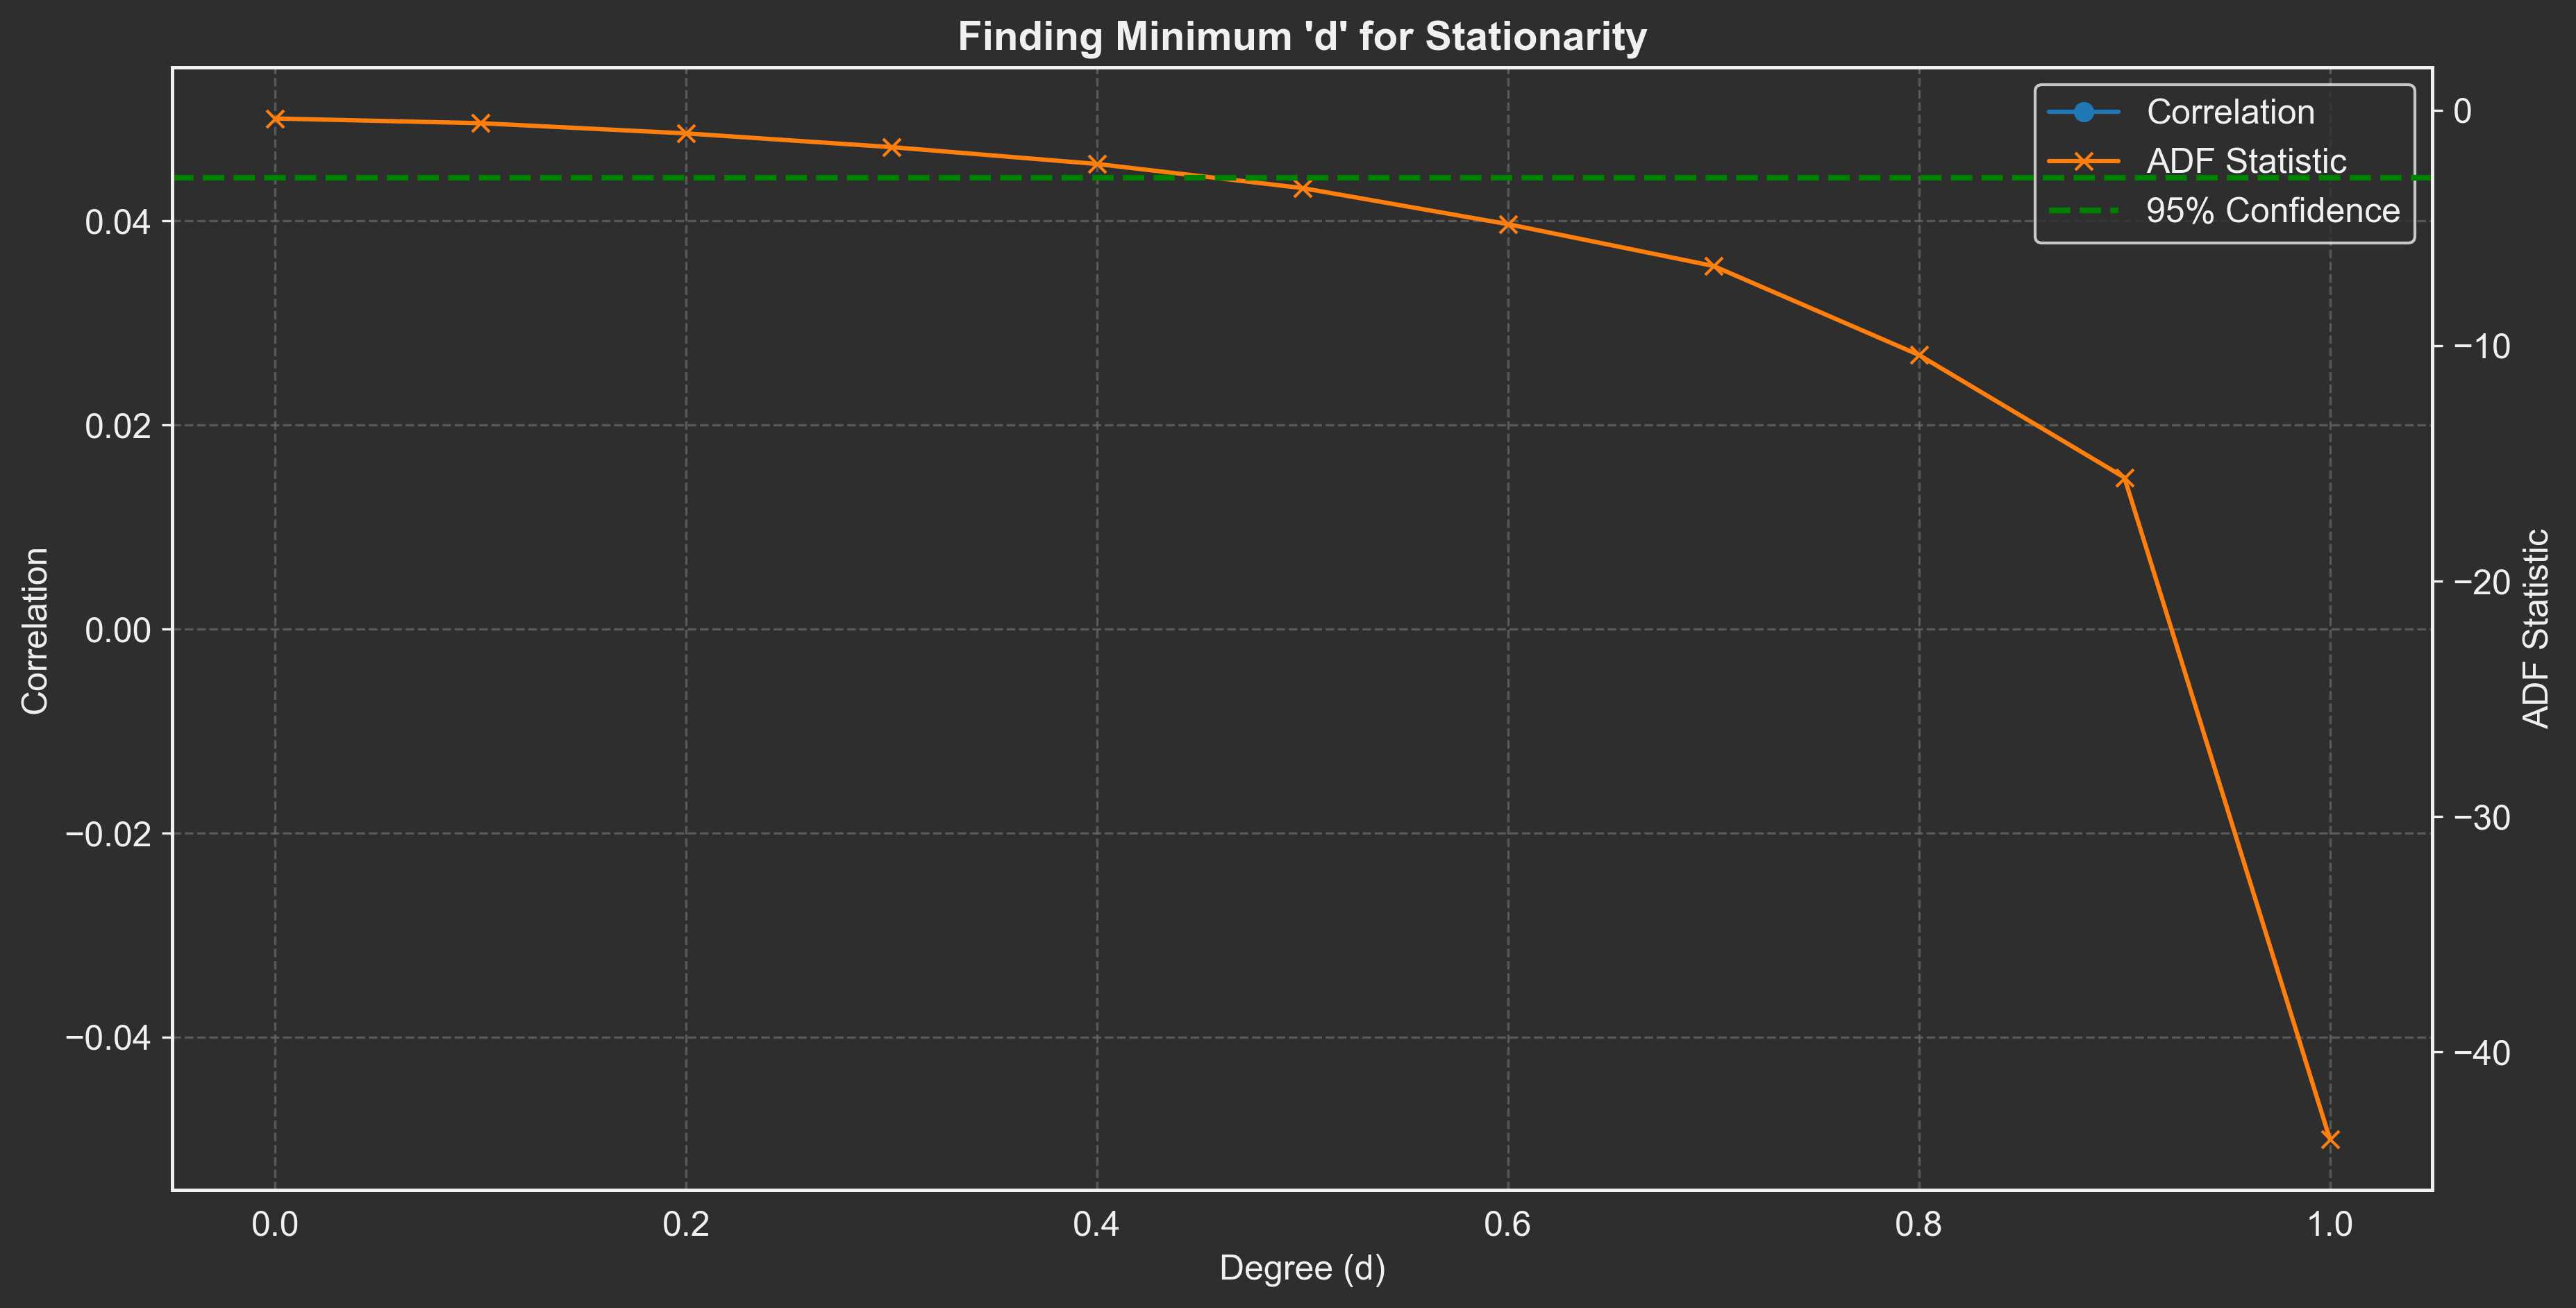

In [7]:
# --- Plotting ---
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(out.index, out['corr'], label='Correlation', color='C0', marker='o')

ax2 = ax.twinx()
ax2.plot(out.index, out['adfStat'], label='ADF Statistic', color='C1', marker='x')
ax2.axhline(
    y=out['95% conf'].mean(), 
    color='green', 
    linestyle='--', 
    linewidth=2, 
    label='95% Confidence'
)

pub_plots.apply_plot_style(
    ax, 
    "Finding Minimum 'd' for Stationarity", 
    'Degree (d)', 
    'Correlation'
)
ax2.set_ylabel('ADF Statistic')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')
ax2.grid(False)

pub_plots.finalize_plot(fig, "optimal_d_adf_plot.png")

**Analysis:** Based on the table and plot, we look for the lowest `d` where the **ADF Statistic** (blue line) drops *below* the **95% confidence level** (green dashed line) and the `pVal` is below our 0.05 threshold. This value is our optimal `d`.

## 6. Applying the Optimal 'd'

Finally, we use the `fractionally_differentiated_log_price` function, which automates this search process.

This function expects a raw price `Series`, not a log-price `Series`.

Optimal series has 241 observations.


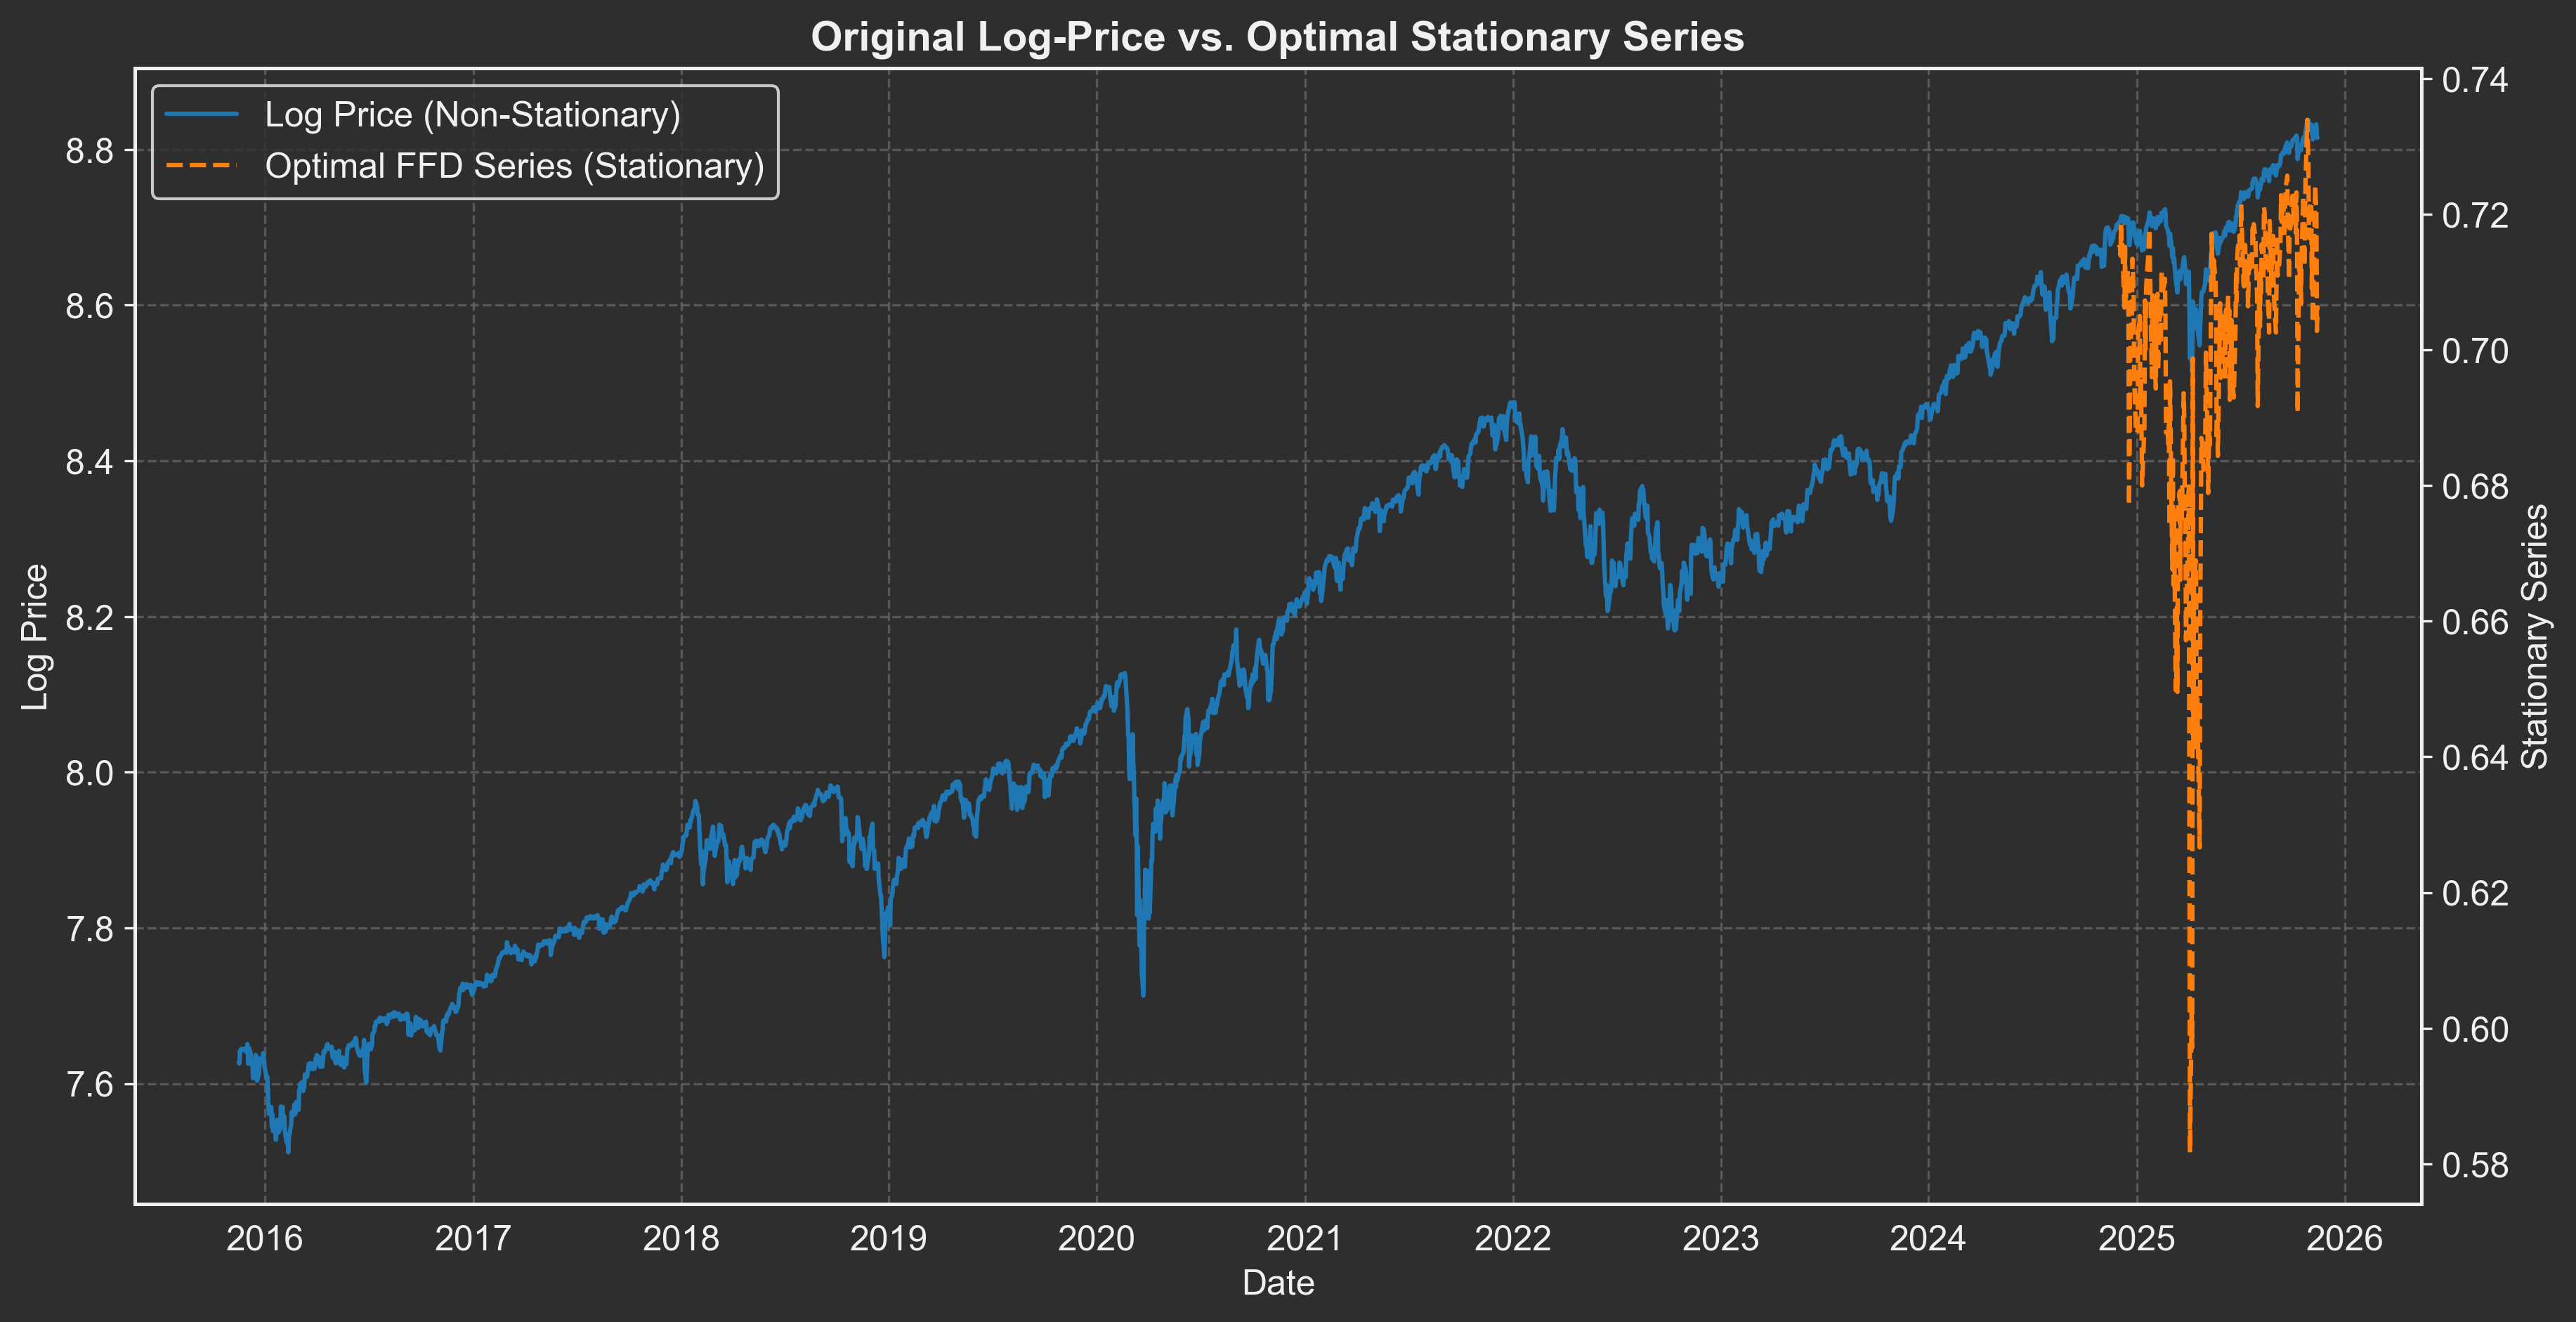

In [8]:
# This function automatically finds the minimum 'd' and returns the series
price_series = series_df['close']

optimal_series = diff.fractionally_differentiated_log_price(
    price_series, 
    step=0.1,  # We can use a coarser step for speed
    p_value_threshold=0.05
)

print(f"Optimal series has {optimal_series.shape[0]} observations.")

# --- Plotting ---
fig, ax = plt.subplots(figsize=(14, 7))
# Plot the original log price
ax.plot(close_log.index, close_log['close'], label='Log Price (Non-Stationary)', color='C0')

ax2 = ax.twinx()
# Plot the new stationary series
ax2.plot(optimal_series.index, optimal_series, label='Optimal FFD Series (Stationary)', color='C1', linestyle='--')

pub_plots.apply_plot_style(
    ax, 
    'Original Log-Price vs. Optimal Stationary Series', 
    'Date', 
    'Log Price'
)
ax2.set_ylabel('Stationary Series')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')
ax2.grid(False)

pub_plots.finalize_plot(fig, "optimal_series_plot.png")